<a href="https://colab.research.google.com/github/Alis192/WEATHER_PREDICTION_NEURAL_NETOWORKS_PROJECT/blob/main/WEATHER_PREDICTION_NEURAL_NETOWORKS_PROJECT_ALAKBAR_DAMIROV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Prediction Project dedicated for Neural Network class

---
**Author**: Alakbar Damirov

**Teacher**: Stefano Melacci

**Note:**: percipation, wind and other features couldn't be seasonal. So it might be unneccessary to forecast them. In this project we will only consider temperature values as input features.



In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Loading the dataset
data = pd.read_csv('seattle-weather.csv')

## Displaying the data
data

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


We have 2 separate columns which are displaying minimum and maximum temperatures. We will combine these two columns into one and insert average value of a day into the column. Since 2012 was a leap year we also remove the record belongs to 29 february so we can reduce the confusion and extra work that could happen.

In [ ]:
## Creating a new column and filling it with values from original columns
data['temp_avg'] = (data['temp_max'] + data['temp_min']) / 2


## Dropping unnecessary tables
data = data.drop(['temp_max', 'temp_min', 'weather', 'precipitation', 'wind'], axis = 1)

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Removing February 29, 2012 data
data = data[~((data['date'].dt.month == 2) & (data['date'].dt.day == 29) & (data['date'].dt.year == 2012))]

data.to_csv()

data

,date,temp_avg
0,2012-01-01,8.90
1,2012-01-02,6.70
2,2012-01-03,9.45
3,2012-01-04,8.90
4,2012-01-05,5.85
...,...,...
1456,2015-12-27,3.05
1457,2015-12-28,3.35
1458,2015-12-29,3.90
1459,2015-12-30,2.30


If GPU is available we will use GPU computation.

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Now we will visualize the data by plotting 'date' in Y axis, 'temp_avg' in X axis.

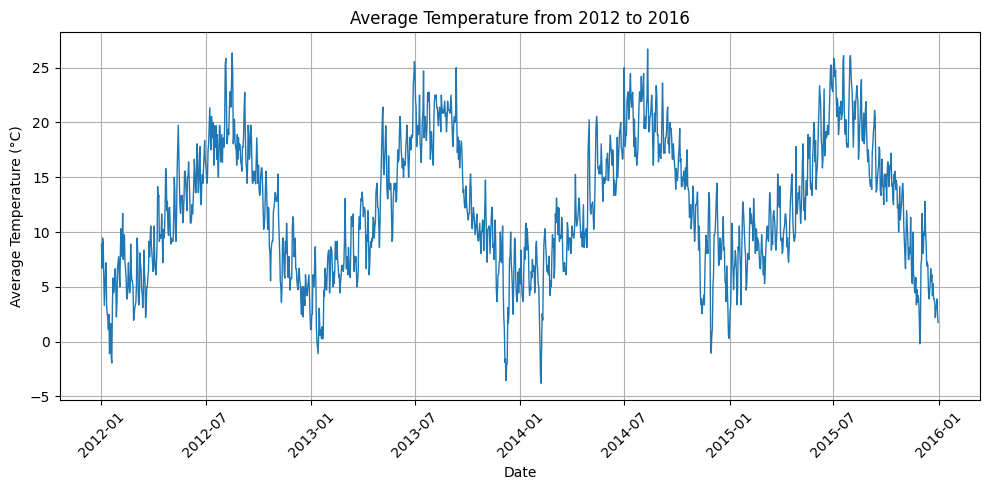

In [ ]:
data['date'] = pd.to_datetime(data['date'])

# Setting the figure size as needed
plt.figure(figsize=(10,5))

plt.plot(data['date'], data['temp_avg'], linestyle='-', marker='None', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature from 2012 to 2016')

# Rotate the dates for better readability
plt.xticks(rotation=45)

# Adding grid lines
plt.grid(True)

# Adjusting the padding of the figure
plt.tight_layout()

# Displaying the plot
plt.show()

In the diagram we observe annual seasonal alternation like sinusoidal function. So we need to train the network on the data which we can assume "one full period" of function. We know that each year depending on seasons we observe temperature differences and it's same for every year. So we take 365 days of data  

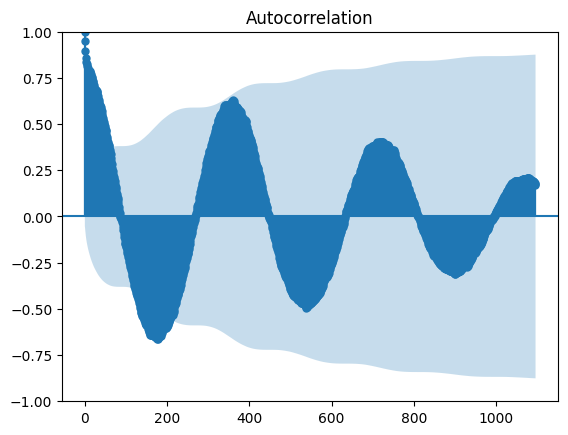

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Assuming `data` is a pandas Series of the temperature data
plot_acf(data['temp_avg'], lags=1095)
plt.show()



We notice that every 365 days the correlation matches since seasons alters. So we take number of lookbacks as 365 days.

---



This part of code transforms original time series in the format which can be used to train LSTM model.

In [ ]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):

    # Makes a deep copy of the input DataFrame to prevent changes to the original data during the transformation process.
    df = dc(df)

    # Sets the 'date' column as the index of the DataFrame
    df.set_index('date', inplace=True)

    # Create a list to hold all the new lagged DataFrames
    lagged_dfs = []

    # Create lagged features and add them to the list
    for i in range(1, n_steps + 1):
        lagged_df = df[['temp_avg']].shift(i).rename(columns={'temp_avg': f'temp_avg(t-{i})'})

        lagged_dfs.append(lagged_df)

    # Concatenate all the lagged DataFrames at once
    df = pd.concat([df] + lagged_dfs, axis=1)

    df.dropna(inplace=True)
    return df



lookback = 365
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df


## print(type(shifted_df))

,temp_avg,temp_avg(t-1),temp_avg(t-2),temp_avg(t-3),temp_avg(t-4),temp_avg(t-5),temp_avg(t-6),temp_avg(t-7),temp_avg(t-8),temp_avg(t-9),...,temp_avg(t-356),temp_avg(t-357),temp_avg(t-358),temp_avg(t-359),temp_avg(t-360),temp_avg(t-361),temp_avg(t-362),temp_avg(t-363),temp_avg(t-364),temp_avg(t-365)
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.10,1.10,2.20,4.15,6.10,5.55,5.00,4.20,4.20,5.25,...,3.35,7.20,6.40,5.00,3.30,5.85,8.90,9.45,6.70,8.90
2013-01-02,2.50,1.10,1.10,2.20,4.15,6.10,5.55,5.00,4.20,4.20,...,2.50,3.35,7.20,6.40,5.00,3.30,5.85,8.90,9.45,6.70
2013-01-03,2.50,2.50,1.10,1.10,2.20,4.15,6.10,5.55,5.00,4.20,...,2.20,2.50,3.35,7.20,6.40,5.00,3.30,5.85,8.90,9.45
2013-01-04,6.10,2.50,2.50,1.10,1.10,2.20,4.15,6.10,5.55,5.00,...,1.10,2.20,2.50,3.35,7.20,6.40,5.00,3.30,5.85,8.90
2013-01-05,5.55,6.10,2.50,2.50,1.10,1.10,2.20,4.15,6.10,5.55,...,2.50,1.10,2.20,2.50,3.35,7.20,6.40,5.00,3.30,5.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,3.05,2.20,3.60,3.90,3.90,5.30,4.20,6.10,5.55,6.65,...,10.80,6.95,3.35,2.80,1.20,0.30,0.60,3.35,4.75,6.90
2015-12-28,3.35,3.05,2.20,3.60,3.90,3.90,5.30,4.20,6.10,5.55,...,9.15,10.80,6.95,3.35,2.80,1.20,0.30,0.60,3.35,4.75
2015-12-29,3.90,3.35,3.05,2.20,3.60,3.90,3.90,5.30,4.20,6.10,...,6.70,9.15,10.80,6.95,3.35,2.80,1.20,0.30,0.60,3.35


Converting the array into numpy array

In [ ]:
shifted_df_np = shifted_df.to_numpy()

shifted_df_np

array([[1.1 , 1.1 , 2.2 , ..., 9.45, 6.7 , 8.9 ],
       [2.5 , 1.1 , 1.1 , ..., 8.9 , 9.45, 6.7 ],
       [2.5 , 2.5 , 1.1 , ..., 5.85, 8.9 , 9.45],
       ...,
       [3.9 , 3.35, 3.05, ..., 0.3 , 0.6 , 3.35],
       [2.3 , 3.9 , 3.35, ..., 1.2 , 0.3 , 0.6 ],
       [1.75, 2.3 , 3.9 , ..., 2.8 , 1.2 , 0.3 ]])

In [ ]:
# 1095 rows, 366 columns array
shifted_df_np.shape

(1095, 366)

To scale our data we transform the features in the range between -1 and 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Transforming current data in the array having size between -1 and  1
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

array([[-0.67868852, -0.67868852, -0.60655738, ..., -0.13114754,
        -0.31147541, -0.16721311],
       [-0.58688525, -0.67868852, -0.67868852, ..., -0.16721311,
        -0.13114754, -0.31147541],
       [-0.58688525, -0.58688525, -0.67868852, ..., -0.36721311,
        -0.16721311, -0.13114754],
       ...,
       [-0.49508197, -0.53114754, -0.55081967, ..., -0.73114754,
        -0.71147541, -0.53114754],
       [-0.6       , -0.49508197, -0.53114754, ..., -0.67213115,
        -0.73114754, -0.71147541],
       [-0.63606557, -0.6       , -0.49508197, ..., -0.56721311,
        -0.67213115, -0.73114754]])

In [ ]:
# All the rows, only columns starting from index 1 (input data)
X = shifted_df_np[:, 1:]

# All the rows, but only first columns (labels)
Y = shifted_df_np[:, 0]

X.shape, Y.shape

((1095, 365), (1095,))

We flip the order of days, because recurringly it gets more updated answer untill it gets to the closest day.

In [ ]:
X = dc(np.flip(X, axis=1))
X

array([[-0.16721311, -0.31147541, -0.13114754, ..., -0.47868852,
        -0.60655738, -0.67868852],
       [-0.31147541, -0.13114754, -0.16721311, ..., -0.60655738,
        -0.67868852, -0.67868852],
       [-0.13114754, -0.16721311, -0.36721311, ..., -0.67868852,
        -0.67868852, -0.58688525],
       ...,
       [-0.53114754, -0.71147541, -0.73114754, ..., -0.60655738,
        -0.55081967, -0.53114754],
       [-0.71147541, -0.73114754, -0.67213115, ..., -0.55081967,
        -0.53114754, -0.49508197],
       [-0.73114754, -0.67213115, -0.56721311, ..., -0.53114754,
        -0.49508197, -0.6       ]])

Since we have the record of 3 years. We want to split our data into 2 separate parts:


1.   Part will be used for training which will cover 2012-2014
2.   Part will be used to test the accuracy of the model. It will cover year 2015



In [ ]:
split_index = 365 * 2

split_index

730

In [ ]:
X_train = X[:split_index] # Data in X from 0 - 730
X_test = X[split_index:] # Data in X from 730 - 1095

Y_train = Y[:split_index] # Data in Y from 0 - 730
Y_test = Y[split_index:] # Data in Y from 730 - 1095

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((730, 365), (730,), (365, 365), (365,))

Pytorch LSTMs by default requires 3D input tensors. So before proceding we need to add one more dimension to our arrays

In [ ]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

Y_train = Y_train.reshape((-1, 1))
Y_test = Y_test.reshape((-1, 1))

# Checking shapes
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((730, 365, 1), (365, 365, 1), (730, 1), (365, 1))

# 1) This part of the code reshapes the input feature arrays **(X_train and X_test)** into the shape expected by the LSTM, which is **[samples, time steps, features]**:



*   ***samples:*** This is the number of data points we're feeding into the model. -1 is a placeholder that tells numpy to automatically calculate this dimension based on the original size of the array and the other dimensions specified.

*   ***lockbacks:*** This is the number of time steps per sample and is set to 365 days in our case. It represents how many past observations the model should consider when making a prediction for the current time step.

* ***features:***  This is the number of features per time step. Since we're only using the average temperature, this is set to 1.


# 2)Reshaping Y_train and Y_test:

This reshapes the target arrays (Y_train and Y_test) to have two dimensions:


*   The first dimension -1 again tells numpy to infer the number of samples
automatically.
*   The second dimension is set to 1 because we're predicting a single value (the temperature) at each time step.


---







Converting NumPy arrays into tensors, so that we can feed our inputs.

In [ ]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

# Checking shapes
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([730, 365, 1]),
 torch.Size([365, 365, 1]),
 torch.Size([730, 1]),
 torch.Size([365, 1]))

Creating **TimeSeriesDataset** class. These dataset objects are then used to create **DataLoader** objects which allows us to iterate over the data in mini-batches during the training process.:

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

# Creates a dataset object from the training data.
train_dataset = TimeSeriesDataset(X_train, Y_train)

# Creates a dataset object from the test data.
test_dataset = TimeSeriesDataset(X_test, Y_test)



In the below code, I initially wanted to define batch size as 365, after doing some research I found out that a batch size of 365 is quite large, especially for LSTM models that typically benefit from seeing more frequent updates. Unless I had a very large dataset. So, after completing the code and running several examples I found 5 is acceptable value. I didn't lower batch size to avoid data overfitting.

I also selected 'shuffle' value as 'False' because it's usually important to maintain the temporal order of the data. Shuffling would disrupt the sequence information, which is crucial for LSTM models.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Here we define **LSTM** (Long-Short term memory) class, so that we can train our model based on **LSTM** logic.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()

        # The size of the LSTM's hidden layers.
        # This is the number of features that the LSTM will output at each time step and is set to 4 in next lines.
        self.hidden_size = hidden_size

        # The number of LSTM layers stacked on top of each other. I chose it 1.
        self.num_stacked_layers = num_stacked_layers

        # This creates an LSTM layer with the specified parameters
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        # We create fully conntected linear layer after the LSTM layer.
        # In this case, you want to predict a single value (the temperature), so the output size is 1.
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):

        # It extracts the batch size from the input x
        batch_size = x.size(0)

        # These are the initial hidden and cell states for the LSTM, initialized to zeros.
        # They're sized according to the num_stacked_layers and hidden_size to match the expected input for the LSTM layer.
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)


        # The LSTM processes the input x using the initial hidden (h0) and cell (c0 states
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        # The final output is the predicted temperature for the next time step after the sequence
        return out


# We create an instance of LSTM class and pass values into it
# input size (1), hidden size (4), number of layers (1)
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

We define a function to train one epoch. Epochs are basically one full iteration where all data are passed through the model. We create many epochs to increase output accuracy per iteration.

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):

        # This unpacks the current batch into inputs (x_batch) and targets (y_batch), and moves them to the specified computing device (CPU or GPU).
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Input is feeded into model and loss is caulculated.
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()


        # Before the model is updated, the gradients are setted to zero. This is necessary because by default, gradients are accumulated in PyTorch.
        optimizer.zero_grad()

        # Here gradients are calculated.
        loss.backward()

        # Optimizer updates model's parameters based on gradient values.
        optimizer.step()

        # Prints average loss in every 5 batches
        if (batch_index + 1 )% 5 == 0:
            avg_loss_across_batches = running_loss / 5
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

The similar process is repeated below. This time model compares output values with the actual temperature values.

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):

        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # We don't want to update parameters. We onlywant to check the model's accuracy
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

Below we execute model training.

In [ ]:
# We define parameters
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Actual training process happens here
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 5, Loss: 1.213
Batch 10, Loss: 0.580
Batch 15, Loss: 0.459
Batch 20, Loss: 0.281
Batch 25, Loss: 0.183
Batch 30, Loss: 0.042
Batch 35, Loss: 0.032
Batch 40, Loss: 0.189
Batch 45, Loss: 0.164
Batch 50, Loss: 0.174
Batch 55, Loss: 0.073
Batch 60, Loss: 0.154
Batch 65, Loss: 0.249
Batch 70, Loss: 0.824
Batch 75, Loss: 0.560
Batch 80, Loss: 0.487
Batch 85, Loss: 0.587
Batch 90, Loss: 0.208
Batch 95, Loss: 0.118
Batch 100, Loss: 0.081
Batch 105, Loss: 0.018
Batch 110, Loss: 0.072
Batch 115, Loss: 0.212
Batch 120, Loss: 0.242
Batch 125, Loss: 0.120
Batch 130, Loss: 0.030
Batch 135, Loss: 0.039
Batch 140, Loss: 0.442
Batch 145, Loss: 0.262

Val Loss: 0.188
***************************************************

Epoch: 2
Batch 5, Loss: 0.776
Batch 10, Loss: 0.315
Batch 15, Loss: 0.234
Batch 20, Loss: 0.130
Batch 25, Loss: 0.082
Batch 30, Loss: 0.034
Batch 35, Loss: 0.065
Batch 40, Loss: 0.225
Batch 45, Loss: 0.197
Batch 50, Loss: 0.203
Batch 55, Loss: 0.072
Batch 60, Loss: 0.064
Ba

After training completion, we test the model's performance.

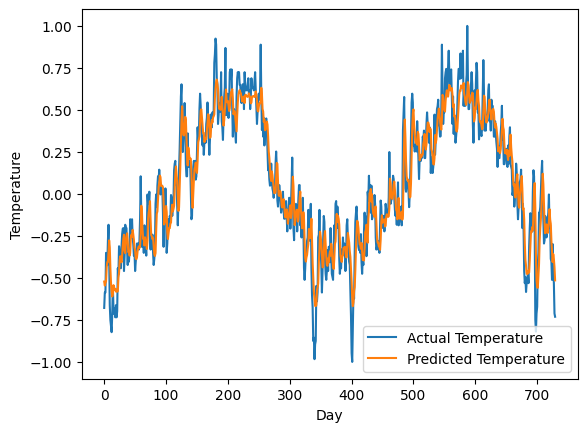

In [ ]:
with torch.no_grad():

    # Numpy doesn't work with GPU so we need to change the computation into CPU
    # We again feed 'X_train' into model to measure its performance.
    predicted = model(X_train.to(device)).to('cpu').numpy()

# We plot graphs of Actual and Predicted temperatures to see how good/bad model performs.
plt.plot(Y_train, label='Actual Temperature')
plt.plot(predicted, label='Predicted Temperature')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()
plt.show()

The temperatures are between -1 and 1 in the plot because we have normalized  the data before feeding it into the LSTM model. In the next steps we will transform the temperature back to its original values. To do that we have to use inverse transformation

## Inverse Transformation

### We will retain previous temperature values in correct format.



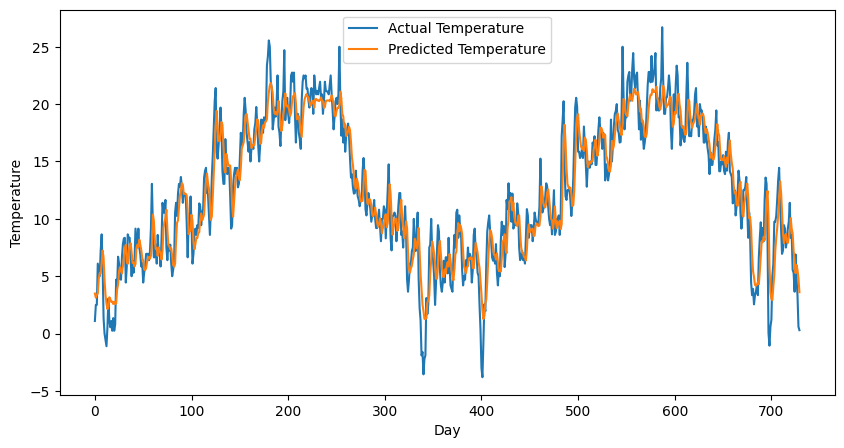

In [ ]:
# Predicts on the training set
train_predictions = model(X_train.to(device)).detach().cpu().numpy().flatten()

# It then places the train_predictions into the first column of the dummy array.
# This is because the MinMaxScaler expects an input with the same number of features as the data it was fit on.
train_predictions_dummy = np.zeros((train_predictions.shape[0], shifted_df_np.shape[1]))

# The slicing [:, 0] selects only the first column of the transformed data, which contains the inversely transformed predictions.
train_predictions_dummy[:, 0] = train_predictions

# The slicing [:, 0] selects only the first column of the transformed data, which contains the inversely transformed predictions.
train_predictions_original = scaler.inverse_transform(train_predictions_dummy)[:, 0]

# A similar dummy array is created for the actual training temperatures (Y_train).
# The actual temperatures are placed in the first column of the new dummy array.
# The inverse_transform method is used again to convert these values back to the original temperature scale.
new_y_train_dummy = np.zeros((Y_train.shape[0], shifted_df_np.shape[1]))
new_y_train_dummy[:, 0] = Y_train.cpu().numpy().flatten()
new_y_train_original = scaler.inverse_transform(new_y_train_dummy)[:, 0]

# Plot the actual vs predicted temperatures for the training set
plt.figure(figsize=(10, 5))
plt.plot(new_y_train_original, label='Actual Temperature')
plt.plot(train_predictions_original, label='Predicted Temperature')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()
plt.show()


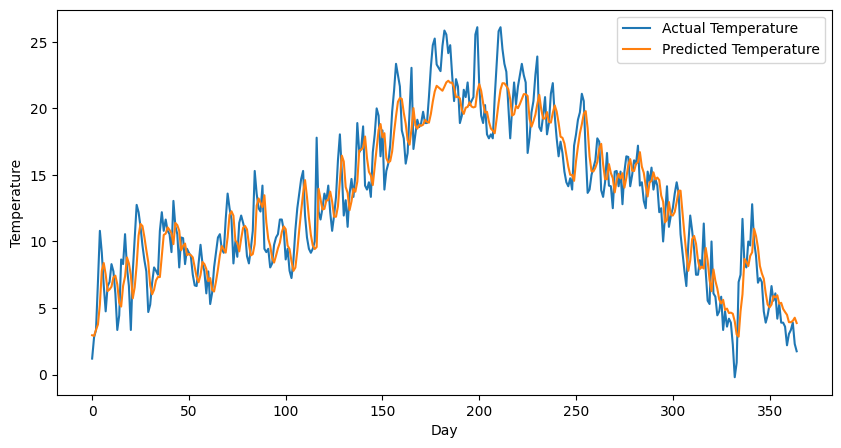

In [ ]:
# Predict on the test set
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()


# The code creates a "dummy" array filled with zeros,
# that has the same number of rows as the train_predictions and the same number of columns as shifted_df_np (the scaled dataset used for training the model).
test_predictions_dummy = np.zeros((test_predictions.shape[0], shifted_df_np.shape[1]))


# It then places the train_predictions into the first column of the dummy array.
# This is because the MinMaxScaler expects an input with the same number of features as the data it was fit on.
test_predictions_dummy[:, 0] = test_predictions

# The slicing [:, 0] selects only the first column of the transformed data, which contains the inversely transformed predictions.
test_predictions_original = scaler.inverse_transform(test_predictions_dummy)[:, 0]


# A similar dummy array is created for the actual training temperatures (Y_train).
# The actual temperatures are placed in the first column of the new dummy array.
# The inverse_transform method is used again to convert these values back to the original temperature scale.
new_y_test_dummy = np.zeros((Y_test.shape[0], shifted_df_np.shape[1]))
new_y_test_dummy[:, 0] = Y_test.cpu().numpy().flatten()
new_y_test_original = scaler.inverse_transform(new_y_test_dummy)[:, 0]


# Plot the actual vs predicted temperatures for the test set
plt.figure(figsize=(10, 5))
plt.plot(new_y_test_original, label='Actual Temperature')
plt.plot(test_predictions_original, label='Predicted Temperature')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()
plt.show()
